In [2]:
!pip install opencv-python

     |████████████████████████████████| 30.0 MB 14.5 MB/s eta 0:00:01


In [17]:
!pip install torchsummary

In [79]:
!pip install seaborn

In [1]:
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchsummary import summary

In [2]:
#Load Images from Swing
trainImages = []
for i in range(0, 1000):
    image = cv2.imread('Dataset/SwingImages/swing_' + str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    trainImages.append(gray_image.reshape(89, 100, 1))

#Load Images From Palm
for i in range(0, 1000):
    image = cv2.imread('Dataset/PalmImages/palm_' + str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    trainImages.append(gray_image.reshape(89, 100, 1))
    
#Load Images From Fist
for i in range(0, 1000):
    image = cv2.imread('Dataset/FistImages/fist_' + str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    trainImages.append(gray_image.reshape(89, 100, 1))

In [3]:
# Create OutputVector
# 三个类别分别为 0， 1， 2
trainLabels = []
for i in range(0, 1000):
    trainLabels.append(0)

for i in range(0, 1000):
    trainLabels.append(1)

for i in range(0, 1000):
    trainLabels.append(2)

In [4]:
testImages = []
# 三个类别分别为 0， 1， 2
#Load Images for swing
for i in range(0, 100):
    image = cv2.imread('Dataset/SwingTest/swing_' + str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    testImages.append(gray_image.reshape(89, 100, 1))

#Load Images for Palm
for i in range(0, 100):
    image = cv2.imread('Dataset/PalmTest/palm_' + str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    testImages.append(gray_image.reshape(89, 100, 1))
    
#Load Images for Fist
for i in range(0, 100):
    image = cv2.imread('Dataset/FistTest/fist_' + str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    testImages.append(gray_image.reshape(89, 100, 1))

testLabels = []

for i in range(0, 100):
    testLabels.append(0)
    
for i in range(0, 100):
    testLabels.append(1)

for i in range(0, 100):
    testLabels.append(2)

In [5]:
class CustomImageDataSet(Dataset):
    def __init__(self, imgs, img_labels, transform = None):
        self.imgs = imgs
        self.img_labels = img_labels
        self.transform = transform
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        image = image.permute(0, 1, 2)
        return image, label

In [6]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5,), (0.5,))])
transform = transforms.ToTensor()

In [7]:
train_data = CustomImageDataSet(trainImages, trainLabels, transform)
test_data = CustomImageDataSet(testImages, testLabels, transform)

In [8]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 2, padding = 1)
        self.conv4 = nn.Conv2d(128, 256, 2, padding = 1)
        #self.conv5 = nn.Conv2d(256, 256, 2, padding = 1)
        self.conv6 = nn.Conv2d(256, 128, 2, padding = 1)
        self.conv7 = nn.Conv2d(128, 64, 2, padding = 1)
        
        self.pool = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(64 * 2 * 2, 1000)
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        
        x = x.view(-1, 64 * 2 * 2) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Net()

In [10]:
train_features, train_labels = next(iter(train_dataloader))

In [11]:
train_features.shape

torch.Size([64, 1, 89, 100])

In [12]:
summary(model, input_size = (1, 89, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 90, 101]             160
         MaxPool2d-2           [-1, 32, 45, 50]               0
            Conv2d-3           [-1, 64, 46, 51]           8,256
         MaxPool2d-4           [-1, 64, 23, 25]               0
            Conv2d-5          [-1, 128, 24, 26]          32,896
         MaxPool2d-6          [-1, 128, 12, 13]               0
            Conv2d-7          [-1, 256, 13, 14]         131,328
         MaxPool2d-8            [-1, 256, 6, 7]               0
            Conv2d-9            [-1, 128, 7, 8]         131,200
        MaxPool2d-10            [-1, 128, 3, 4]               0
           Conv2d-11             [-1, 64, 4, 5]          32,832
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Linear-13                 [-1, 1000]         257,000
           Linear-14                   

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [15]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [16]:
device = 'cpu'

In [17]:
from tqdm.notebook import tqdm

In [18]:
print("Begin training.")
for e in tqdm(range(1, 51)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_dataloader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in test_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_dataloader))
    loss_stats['val'].append(val_epoch_loss/len(test_dataloader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_dataloader))
    accuracy_stats['val'].append(val_epoch_acc/len(test_dataloader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_dataloader):.5f} | Val Loss: {val_epoch_loss/len(test_dataloader):.5f} | Train Acc: {train_epoch_acc/len(train_dataloader):.3f}| Val Acc: {val_epoch_acc/len(test_dataloader):.3f}')

Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 1.09862 | Val Loss: 1.09816 | Train Acc: 33.362| Val Acc: 32.000
Epoch 02: | Train Loss: 1.09840 | Val Loss: 1.09897 | Train Acc: 33.383| Val Acc: 30.000
Epoch 03: | Train Loss: 1.09824 | Val Loss: 1.09935 | Train Acc: 35.149| Val Acc: 30.000
Epoch 04: | Train Loss: 1.09805 | Val Loss: 1.09778 | Train Acc: 33.426| Val Acc: 41.000
Epoch 05: | Train Loss: 1.09796 | Val Loss: 1.09786 | Train Acc: 39.830| Val Acc: 45.000
Epoch 06: | Train Loss: 1.09772 | Val Loss: 1.09785 | Train Acc: 39.511| Val Acc: 29.000
Epoch 07: | Train Loss: 1.09759 | Val Loss: 1.09774 | Train Acc: 33.362| Val Acc: 27.000
Epoch 08: | Train Loss: 1.09742 | Val Loss: 1.09724 | Train Acc: 53.511| Val Acc: 91.000
Epoch 09: | Train Loss: 1.09719 | Val Loss: 1.09735 | Train Acc: 43.234| Val Acc: 34.000
Epoch 10: | Train Loss: 1.09703 | Val Loss: 1.09694 | Train Acc: 43.319| Val Acc: 32.000
Epoch 11: | Train Loss: 1.09682 | Val Loss: 1.09717 | Train Acc: 33.426| Val Acc: 29.000
Epoch 12: | Train Los

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

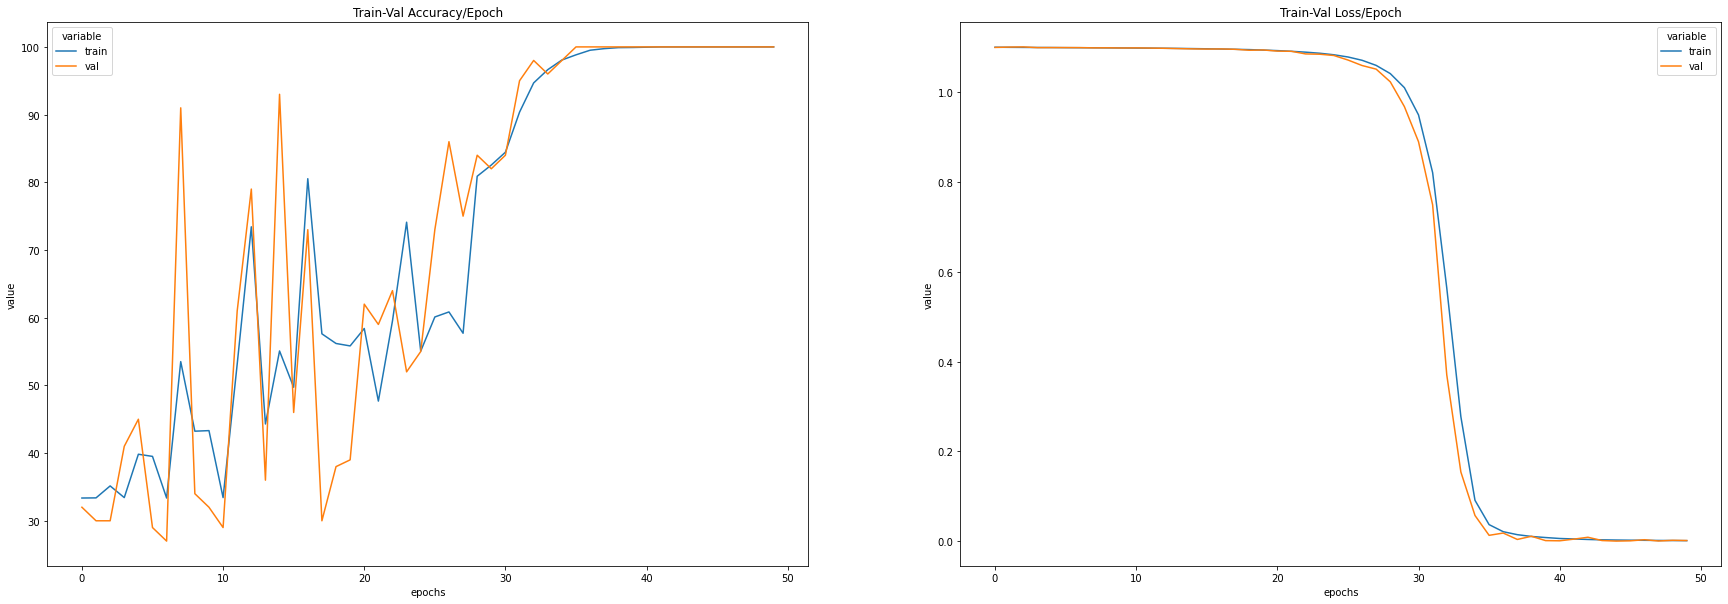

In [20]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')


In [25]:
torch.save(model, './model/demo.pt')